## 1. Loading Libraries


In [1]:
# Importing the Required Library
import pandas as  pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,Activation,Conv2D,MaxPooling2D,Flatten, BatchNormalization, MaxPool2D
from tensorflow.keras.metrics import AUC
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator



## 2. Loading Data

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
x_test = pd.read_csv('../input/digit-recognizer/test.csv')

# taking the independent feature and the dependent feature in xtrain and ytrain of the traning data
x_train = train.drop(columns = 'label')
y_train = train['label']
x_train.shape
counter = 0

In [3]:
x_train.shape

(42000, 784)

In [4]:
x_test.shape

(28000, 784)

## 2. Reshaping & Normalization  
Let's separate the data and labels. It turns out that training data is of shape **(42000, 784)**. So the train set has 42000 inidividual images which are square image but unwinded to arrays of length 784. Lets make it into the image size of **28x28** so that we can plot and see. The pixel values are in th range of **[0, 255]**. Let's normalize them in the range **[0, 1]** for the convinence of CNN layers. 


In [5]:
x_train = x_train.values.reshape(-1, int(np.sqrt(784)), int(np.sqrt(784)), 1)/255.0
x_test =  x_test.values.reshape(-1, int(np.sqrt(784)), int(np.sqrt(784)), 1)/255.0

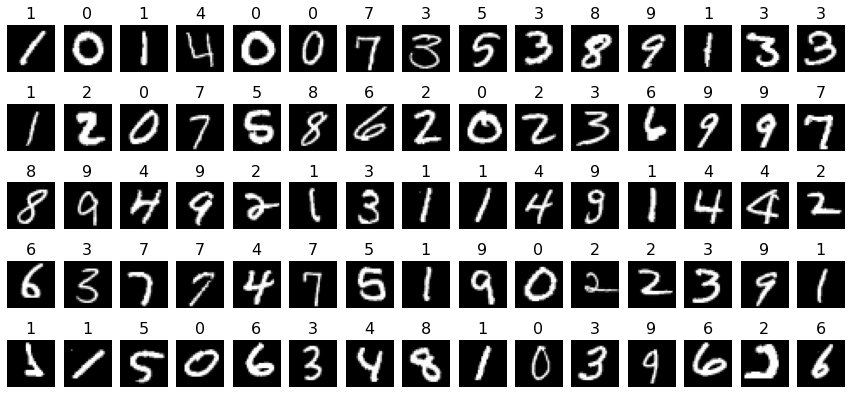

In [6]:
rows = 5
cols = 15
fig = plt.figure(figsize=(15,7))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.squeeze(x_train[counter + i-1]), cmap='gray')
    plt.title(y_train[counter + i-1], fontsize=16)
    plt.axis(False)
    fig.add_subplot
counter += rows*cols

The orginal dataset has the labels numbered all the way from 0 to 9. However, this is not convinent for the CNN target output. Therefore, for the ease of classification model,  let's convert them into one hot vectors for each labels. 

In [7]:
y_train = to_categorical(y_train, num_classes=10)

## 3. Splitting Up Train and Validation Set
Original dataset doesn't have the train validation set separate. Therefore, in order to fine tune the model, we separate **10%** of the train data as hold out cross validation set. 

In [8]:
x_train_trim ,x_valid , y_train_trim, y_valid = train_test_split(x_train, y_train, test_size= 0.1 ,random_state = 1455)
print(f'Training Set size: {x_train_trim.shape[0]}')
print(f'Validation Set size: {x_valid.shape[0]}')

Training Set size: 37800
Validation Set size: 4200


## 4. Model Building & Compilation
### 4.1 Creating Model


In [9]:
x_train_trim.shape[-3:]

(28, 28, 1)

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

### 4.2 Creating Callbacks
The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process. Therefore let's take a learning rate scheduler from built in library then incorporate a scheduler to vary learning rate over time. 
And another thing is the saving the model after training. However, during the training process the accuarcy of the model can go down. But if we are able to save the best possible state if the network over time, then it is possible to get the maximum out of the model.  

In [11]:
def build_lrfn(lr_start=1e-4, lr_max=1e-3, 
               lr_min=0, lr_rampup_epochs=16, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = LearningRateScheduler(lrfn, verbose=True)



#Usually monitor='val_accuracy' should be tracked here. Since the training set is smaller let keep it limited to accuracy
checkpoint = ModelCheckpoint(
    filepath='best_weights.hdf5',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

optimizer_rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train_trim)

## 4.3 Compilation and Training

In [13]:
model.compile(optimizer=optimizer_rmsprop, 
              loss = 'categorical_crossentropy',  
              metrics = ['accuracy'])

batch_size = 512
epochs = 40

""" 
Batch Size Variation epoch = 40 
        batch size --->> accuracy
        86         --->> 99.442
        128        --->> 99.489
        256        --->> 99.525
        512        --->>   ?
"""


train_history = model.fit_generator(datagen.flow(x_train_trim, y_train_trim, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_valid,y_valid),
                              verbose = 2, steps_per_epoch=x_train_trim.shape[0] // batch_size
                              , callbacks=[lr_schedule, checkpoint])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
73/73 - 10s - loss: 1.7224 - accuracy: 0.4076 - val_loss: 0.7040 - val_accuracy: 0.8221 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00015625.
Epoch 2/40
73/73 - 10s - loss: 0.9997 - accuracy: 0.6724 - val_loss: 0.2747 - val_accuracy: 0.9314 - lr: 1.5625e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00021250000000000002.
Epoch 3/40
73/73 - 11s - loss: 0.5716 - accuracy: 0.8188 - val_loss: 0.1471 - val_accuracy: 0.9588 - lr: 2.1250e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00026875.
Epoch 4/40
73/73 - 10s - loss: 0.3815 - accuracy: 0.8813 - val_loss: 0.1006 - val_accuracy: 0.9676 - lr: 2.6875e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000325.
Epoch 5/40
73/73 - 10s - loss: 0.2927 - accuracy: 0.9100 - val_loss: 0.0816 - val_accuracy: 0.9731 - lr: 3.2500e-04

Epoch 00006: LearningRateScheduler reducing

## 4.4 Observe Training History
Now the training is done, let's have a look at the training history. It is very crucial to determine whether the model is overfitting or not.

In [14]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(history.history['lr'], label = 'lr', marker = '*',linewidth = lw)
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

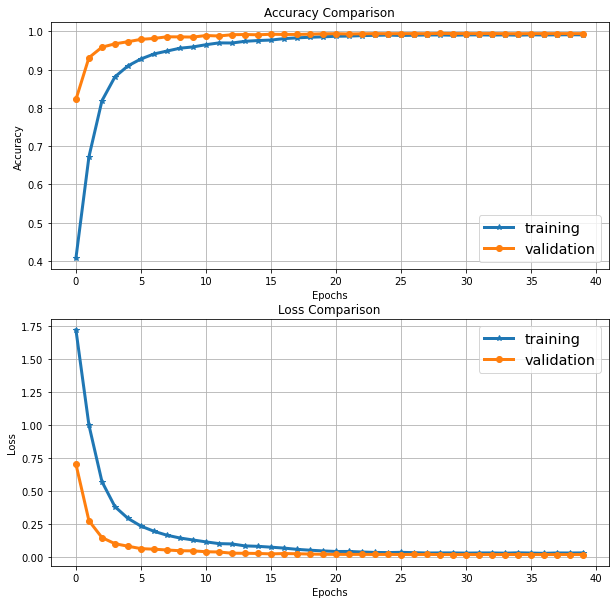

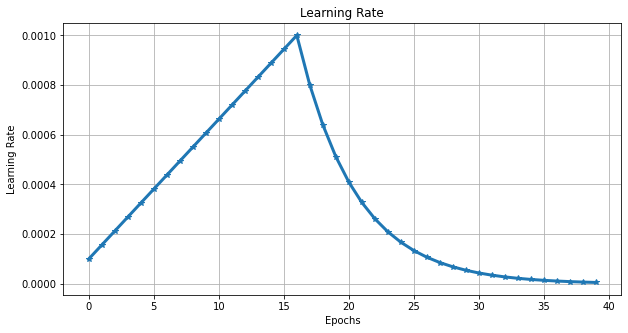

In [15]:
visualize_training(train_history) 

## 5. Inference and Submission Generation
Lets generate the predictions from the test set and have a look at the performance. 

In [16]:
model.load_weights('./best_weights.hdf5')
predictions_probs  = model.predict(x_test)
predictions = np.argmax(predictions_probs, axis = 1)
counter = 0

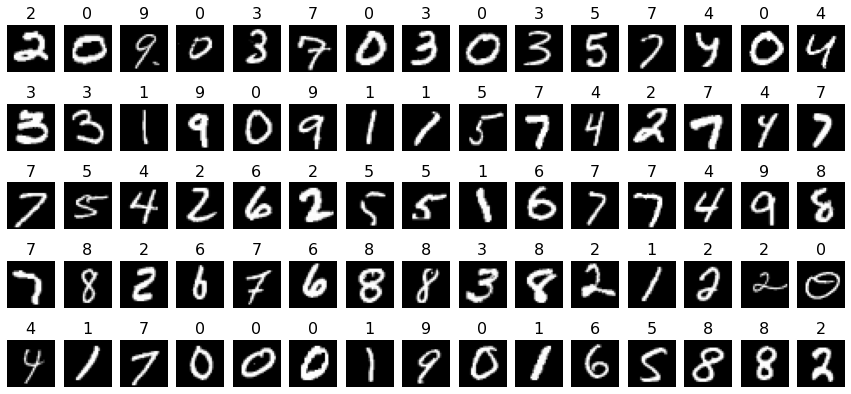

In [17]:
rows = 5
cols = 15
fig = plt.figure(figsize=(15,7))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.squeeze(x_test[counter + i-1]), cmap='gray')
    plt.title(predictions[counter + i-1], fontsize=16)
    plt.axis(False)
    fig.add_subplot
counter += rows*cols

In [18]:
ImageId = np.arange(1,x_test.shape[0] + 1)
output = pd.DataFrame({'ImageId':ImageId, 'Label':predictions})
output.to_csv('submission.csv', index=False)
print(output)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
